Identifying Animal Species in Camera
Trap Images using Deep Learning and Citizen Science

Your task is to provide the probability that an image contains a zebra.


In [ ]:
# load all required libraries
import os
import shutil
from skimage import io
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random


In [ ]:
#Importing the dataset by mounting it from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !mkdir -p {all_images_path,train_images_path,test_images_path,validation_images_path}
!mkdir -p '/content/animal_classfication/combined'
!mkdir -p '/content/animal_classfication/train/zebras'
!mkdir -p '/content/animal_classfication/train/elephants'
!mkdir -p '/content/animal_classfication/test/'
!mkdir -p '/content/animal_classfication/test/test/'

In [ ]:
# unzip the three basic zipped files
!unzip -q '/content/gdrive/My Drive/images_work/classfication/train_elephants.zip'  -d  '/content/animal_classfication/combined/'
!unzip -q '/content/gdrive/My Drive/images_work/classfication/train_zebras.zip'  -d  '/content/animal_classfication/combined/'
!unzip -q '/content/gdrive/My Drive/images_work/classfication/animal_test_data.zip'  -d  '/content/animal_classfication/test/'

In [ ]:
# Environmental Paths to use in subsequent code refererences
all_images_path = '/content/animal_classfication/combined/'
train_dir = '/content/animal_classfication/train/'
train_zebras = '/content/animal_classfication/train/zebras'
train_elephants= '/content/animal_classfication/train/elephants'
test_images_path = '/content/animal_classfication/test/test/'
submission='/content/gdrive/My Drive/images_work/classfication/sampleSubmission.csv'

In [ ]:
# Copy all zebras from zebra folder to combined folder
zebras='/content/animal_classfication/combined/train_zebras/'
lists=os.listdir(zebras)
for f in lists:
    shutil.copy(zebras+f,train_zebras)
    shutil.move(zebras+f,all_images_path)

In [ ]:
# copy all elephants to combined folder
elephants='/content/animal_classfication/combined/train_elephants/'
lists=os.listdir(elephants)
for f in lists:
    shutil.copy(elephants+f,train_elephants)
    shutil.move(elephants+f,all_images_path)

In [ ]:
# copy all elephants to combined folder
test_images_path='/content/animal_classfication/test/'
lists=os.listdir(test_images_path)

In [ ]:
# Count each class training images
elephant_training_set=os.listdir(train_elephants)
print('Elephants: '+str(len(elephant_training_set)))

zebra_training_set=os.listdir(train_zebras)
print('zebras: '+str(len(zebra_training_set)))

Elephants: 7000
zebras: 7000


In [ ]:
# remove all other folders from combined folder apart from test.
image_path = '/content/animal_classfication/combined/'
for f in image_file_names:
  if os.path.isdir(image_path+f):
    print(f)
    iss=image_path+f
    if iss!="test":
      shutil.rmtree(image_path+f)

In [ ]:
# remove all other folders from test folder (__MACOSX)
test_path = '/content/animal_classfication/test/'
image_file_names=os.listdir(test_path)
for f in image_file_names:
  if os.path.isdir(test_path+f):
    iss=image_path+f
    if f=="__MACOSX":
      shutil.rmtree(test_path+f)

/content/animal_classfication/combined/test


In [ ]:
#Function to upload and if need be resize the training images
def display_images(image_path):
    images = []
    labels = []
    file_names =[]
    image_file_names = [os.path.join(image_path, f) for f in os.listdir(image_path)]        
    # Read the images and load them into an array
    for file in image_file_names[0:5]:         
      image=io.imread(file) #io package from SKimage package
      images.append(np.array(image))
      file_names.append(file)
      
      #Display image
      plt.axis('off')
      plt.imshow(image)
      plt.show()
      print("Size of this image is " + str(image.shape))
      print("Image path is " + str(file))        
      # print("Image name is " + str(image_names[index]))   

    return images,  file_names #labels

In [ ]:
train_mask_matrix,file_names = display_images('/content/animal_classfication/test/test')

In [ ]:
VALIDATION_SPLIT = 0.3
TRAIN_IMAGES = 9800
VAL_IMAGES = 4200
IMAGE_SIZE = [330, 330]
BATCH_SIZE = 32

In [ ]:
import tensorflow as tf
from keras import optimizers,layers,models
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = [330,330, 3]), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 328, 328, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 164, 164, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 162, 162, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 81, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 209952)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               26873984  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
#Define Call backs and learning rate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, 
                                           factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:

split = 0.3
datagen = ImageDataGenerator(validation_split=split, rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir, 
                                              target_size =(IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              shuffle=True,
                                              subset='training')

val_generator = datagen.flow_from_directory(train_dir,
                                            target_size =(IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode='binary',
                                            shuffle=True,
                                            subset='validation')

test_generator = datagen.flow_from_directory('/content/animal_classfication/test/', class_mode='binary',
                                             batch_size = BATCH_SIZE, target_size = IMAGE_SIZE)

Found 9800 images belonging to 2 classes.
Found 4199 images belonging to 2 classes.
Found 5999 images belonging to 1 classes.


In [ ]:
ls=os.listdir('/content/animal_classfication/test/test/')
print(len(ls))

5999


In [ ]:
# remove all other files that are not images in test folder
test_path = '/content/animal_classfication/test/test/'
image_file_names=os.listdir(test_path)
for f in image_file_names:
  if not f.endswith('jpeg'):
    iss=image_path+f
    os.remove(test_path+f)

In [ ]:
epochs = 20

history = model.fit_generator(
train_generator,
epochs = epochs,
validation_data = val_generator,
validation_steps=VAL_IMAGES//BATCH_SIZE,
steps_per_epoch = TRAIN_IMAGES//BATCH_SIZE,
callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
306/306 [==============================] - 1235s 4s/step - loss: 0.5139 - accuracy: 0.8258 - val_loss: 0.5743 - val_accuracy: 0.7464
Epoch 2/20
306/306 [==============================] - 1247s 4s/step - loss: 0.1571 - accuracy: 0.9370 - val_loss: 0.9731 - val_accuracy: 0.6271
Epoch 3/20
306/306 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9719
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
306/306 [==============================] - 1238s 4s/step - loss: 0.0715 - accuracy: 0.9719 - val_loss: 0.9886 - val_accuracy: 0.7257
Epoch 4/20
306/306 [==============================] - 1251s 4s/step - loss: 0.0302 - accuracy: 0.9893 - val_loss: 1.1994 - val_accuracy: 0.7214
Epoch 5/20
306/306 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9928
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
306/306

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

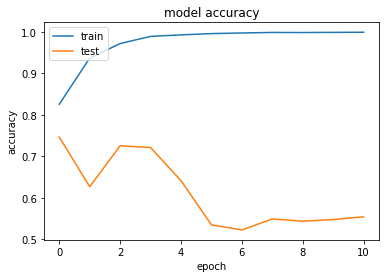

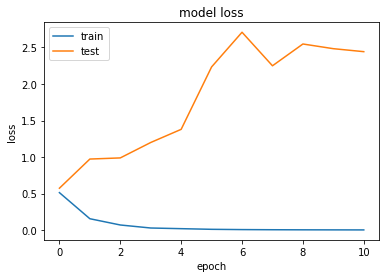

In [ ]:
#Visualizing the loss and the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Let's prepare the test data
test_filenames = os.listdir("/content/animal_classfication/test/test/")

test_df = pd.DataFrame({
    'id': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
print(test_df)

                     id  Label
0     ASG001e1v4_1.jpeg      0
1     ASG001ekkt_2.jpeg      0
2     ASG001elgf_2.jpeg      0
3     ASG001e13h_0.jpeg      0
4     ASG00165mh_0.jpeg      0
...                 ...    ...
5994  ASG001e1v4_2.jpeg      0
5995  ASG001fx0k_0.jpeg      0
5996  ASG0014ir9_0.jpeg      0
5997  ASG00184tn_2.jpeg      0
5998  ASG001bgjd_1.jpeg      0

[5999 rows x 2 columns]


In [ ]:
#Making the predictions
predict = model.predict_generator(test_generator,
                                 steps = np.ceil(nb_samples/BATCH_SIZE))

In [ ]:
test_df.tail(10)

,id,Label
5989,ASG001fcf9_2.jpeg,0
5990,ASG001e0xt_2.jpeg,0
5991,ASG001ekv6_2.jpeg,0
5992,ASG001987c_0.jpeg,0
5993,ASG001em43_2.jpeg,0
5994,ASG001e1v4_2.jpeg,0
5995,ASG001fx0k_0.jpeg,0
5996,ASG0014ir9_0.jpeg,0
5997,ASG00184tn_2.jpeg,0
5998,ASG001bgjd_1.jpeg,0


In [ ]:
#convert labels to categories
test_df['Label'] = np.argmax(predict, axis=1)

label_map = dict((v,k) for k,v in
                train_generator.class_indices.items())

test_df['Label'] = test_df['Label'].replace(label_map)

test_df['Label'] = test_df['Label'].replace({'zebras': 1,'elephants': 0})

In [ ]:
# export our predication to submission csv
test_df.to_csv(submission, encoding='utf-8')

In [ ]:
print('It was awesome')

It was awesome
